### The goal of this notebook is to combine the 3 perspectives that were created in order to obtain final clusters that characterize the customers and allow the definition of marketing strategies.

The four perspectives are:

- Behavioral
- Loyalty
- Value Based

In [1]:
import pandas as pd
import numpy as np
!pip install minisom

# Custom Modules
import sys
from minisom import MiniSom

from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mpl_colors
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import plotly.express as px
import matplotlib.cm as cm


In [50]:
df = pd.read_csv("df_ready_for_clustering.csv")
df.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,0,6.250000,0.026667,0.040000,0.146667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,0,6.805556,0.077551,0.024490,0.114286,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,0,5.861111,0.094787,0.000000,0.066351,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,0,3.000000,0.000000,0.111111,0.027778,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,0,5.027778,0.022099,0.027624,0.165746,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [51]:
df.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr',
       'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov',
       'sr_dec', 'Province or State', 'Education', 'Income', 'Marital Status',
       'LoyaltyStatus', 'EnrollmentMonth', 'Time on Program', 'Cancelled',
       'Reenroll', 'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [52]:
# Define column types
binary_columns = ['EnrollmentType', 'Cancelled']
frequency_column = 'Province or State'
onehot_columns = ['CustomerSegment', 'Education', 'Marital Status', 'LoyaltyStatus']

# Get numerical columns (exclude categorical, datetime, and timedelta columns)
all_categorical = binary_columns + [frequency_column] + onehot_columns

# Identify datetime and timedelta columns to exclude
datetime_cols = df.select_dtypes(include=['datetime64', 'timedelta64']).columns.tolist()

# Get only numeric columns that are not categorical or datetime
numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in all_categorical]

# 1. MINMAX SCALING on numerical columns directly in df
if len(numerical_cols) > 0:
    scaler = MinMaxScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 2. BINARY ENCODING directly in df
#for col in binary_columns:
#    if col in df.columns:
#        df[col] = (df[col] == df[col].unique()[1]).astype(int)

# Frequency encoding
#if frequency_column in df.columns:
#    freq_map = df[frequency_column].value_counts(normalize=True)
#    df[frequency_column] = df[frequency_column].map(freq_map)

# 4. ONE-HOT ENCODING directly in df
#for col in onehot_columns:
#    if col in df.columns:
#        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
#        dummies = dummies.astype(int)
#        df.drop(col, axis=1, inplace=True)
#        for dummy_col in dummies.columns:
#            df[dummy_col] = dummies[dummy_col]

# 5. CONVERT ALL REMAINING BOOLEAN COLUMNS TO INT
#bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
#if len(bool_cols) > 0:
 #   df[bool_cols] = df[bool_cols].astype(int)

#print("\n" + "="*60)
#print(f"Transformation complete")
#print(f"Final df shape: {df.shape}")
#print(f"Datetime columns kept as-is: {datetime_cols}")
#print(f"NaN count: {df.isnull().sum().sum()}")
#print(f"\nData types in df:")
#print(df.dtypes.value_counts())
df.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,Bachelor,0.828927,Married,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,College,0.000000,Single,Nova,0.181818,0.860852,N,0.0,Standard,0.012155
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,College,0.000000,Divorced,Nova,0.545455,0.358621,N,0.0,Standard,0.011545
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,Bachelor,0.428451,Married,Star,0.636364,0.503854,N,0.0,Standard,0.027909
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,Bachelor,0.809944,Divorced,Star,0.000000,0.736714,N,0.0,Standard,0.058015


In [53]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:")
print(numerical_cols)

Numeric columns:
['PointsRedeemedRatio', 'FlightsWithCompanionsRatio', 'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints', 'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Income', 'EnrollmentMonth', 'Time on Program', 'Reenroll', 'Customer Lifetime Value']


## Value Based and Loyalty

In [5]:
value_based_cluster = pd.read_csv("value_based_clusters.csv")
value_based_cluster['kr3_cluster'] = value_based_cluster['kr3_cluster'].replace(3, -1)
value_based_cluster.head()

,kr3_cluster
0,0
1,0
2,1
3,0
4,0


In [6]:
loyalty_cluster = pd.read_csv("loyalty_cluster.csv")
loyalty_cluster.drop(columns=['Unnamed: 0'], inplace=True)
loyalty_cluster.head()

,kmeans_cluster
0,2
1,0
2,2
3,1
4,0


In [7]:
# VB_col is the list of columns related to value-based perspective
VB_col = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint'
]

LO_col = [ 'Time on Program', 'EnrollmentMonth']


In [8]:
df["VALUE_BASED_CLUSTER"] = value_based_cluster["kr3_cluster"]
df["LOYALTY_CLUSTER"] = loyalty_cluster["kmeans_cluster"]
df.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,VALUE_BASED_CLUSTER,LOYALTY_CLUSTER
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,Married,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946,0,2
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,Single,Nova,0.181818,0.860852,N,0.0,Standard,0.012155,0,0
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,Divorced,Nova,0.545455,0.358621,N,0.0,Standard,0.011545,1,2
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,Married,Star,0.636364,0.503854,N,0.0,Standard,0.027909,0,1
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,Divorced,Star,0.000000,0.736714,N,0.0,Standard,0.058015,0,0


In [9]:
print(df.columns.tolist())


['PointsRedeemedRatio', 'FlightsWithCompanionsRatio', 'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints', 'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State', 'Education', 'Income', 'Marital Status', 'LoyaltyStatus', 'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll', 'EnrollmentType', 'Customer Lifetime Value', 'VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER']


In [10]:
df_centroids = df[(df['VALUE_BASED_CLUSTER'] != -1) & (df['LOYALTY_CLUSTER'] != -1)] \
    .groupby(['VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER'])[VB_col + LO_col].mean()
df_centroids

Customer Lifetime Value  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                            
0                   0                               0.074188   
                    1                               0.071821   
                    2                               0.073557   
1                   0                               0.067447   
                    1                               0.072975   
                    2                               0.076200   
2                   0                               0.100979   
                    1                               0.101841   
                    2                               0.093541   

                                     UnredeemedPoints  PointsRedeemedRatio  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                          
0                   0                        0.315863             0.008668   
                    1                        0.399819             0.008816   
                    2                        0.210498             0.008555   
1                   0                        0.337109             0.008065   
                    1                        0.415875             0.008487   
                    2                        0.231130             0.008984   
2                   0                        0.327870             0.008669   
                    1                        0.395803             0.008516   
                    2                        0.209078             0.008804   

                                     KMPerRedeemedPoint  Time on Program  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                        
0                   0                          0.106658         0.385391   
                    1                          0.136785         0.772403   
                    2                          0.072175         0.193032   
1                   0                          0.130852         0.392170   
                    1                          0.155880         0.767440   
                    2                          0.089924         0.194553   
2                   0                          0.121747         0.381582   
                    1                          0.143911         0.778289   
                    2                          0.074576         0.198596   

                                     EnrollmentMonth  
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                   
0                   0                       0.189189  
                    1                       0.656171  
                    2                       0.757335  
1                   0                       0.188185  
                    1                       0.671630  
                    2                       0.749532  
2                   0                       0.195049  
                    1                       0.675595  
                    2                       0.751281

Text(0, 0.5, 'Euclidean Distance')

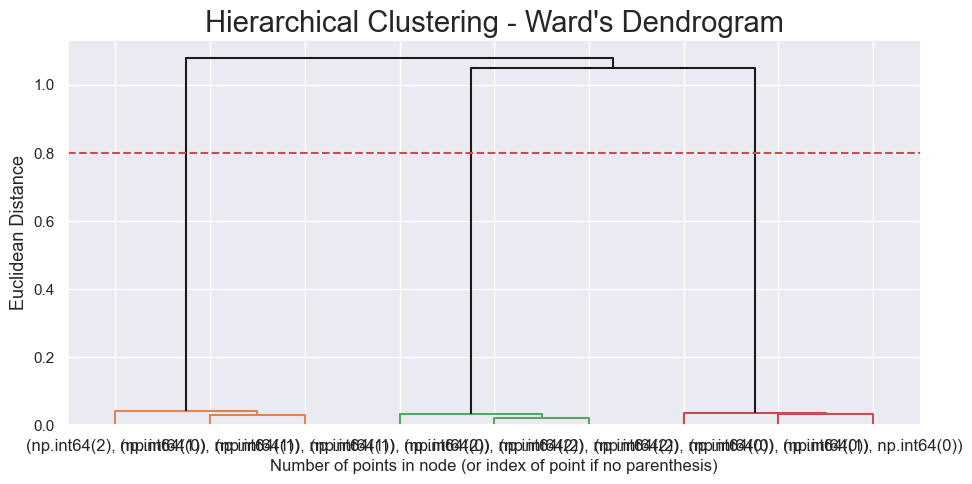

In [11]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 0.8
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)

In [12]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters= 3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Customer Lifetime Value  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                            
0                   0                               0.074188   
                    1                               0.071821   
                    2                               0.073557   
1                   0                               0.067447   
                    1                               0.072975   
                    2                               0.076200   
2                   0                               0.100979   
                    1                               0.101841   
                    2                               0.093541   

                                     UnredeemedPoints  PointsRedeemedRatio  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                          
0                   0                        0.315863             0.008668   
                    1                        0.399819             0.008816   
                    2                        0.210498             0.008555   
1                   0                        0.337109             0.008065   
                    1                        0.415875             0.008487   
                    2                        0.231130             0.008984   
2                   0                        0.327870             0.008669   
                    1                        0.395803             0.008516   
                    2                        0.209078             0.008804   

                                     KMPerRedeemedPoint  Time on Program  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                        
0                   0                          0.106658         0.385391   
                    1                          0.136785         0.772403   
                    2                          0.072175         0.193032   
1                   0                          0.130852         0.392170   
                    1                          0.155880         0.767440   
                    2                          0.089924         0.194553   
2                   0                          0.121747         0.381582   
                    1                          0.143911         0.778289   
                    2                          0.074576         0.198596   

                                     EnrollmentMonth  hclust_labels  
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                  
0                   0                       0.189189              1  
                    1                       0.656171              0  
                    2                       0.757335              2  
1                   0                       0.188185              1  
                    1                       0.671630              0  
                    2                       0.749532              2  
2                   0                       0.195049              1  
                    1                       0.675595              0  
                    2                       0.751281              2

In [13]:
df_ = df.copy()

# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

# Mapping the hierarchical clusters on the centroids to the observations
def safe_map(row):
    key = (row['VALUE_BASED_CLUSTER'], row['LOYALTY_CLUSTER'])
    return cluster_mapper.get(key, -1)  # keep -1 for outliers

df_['Merged_Cluster_1'] = df_.apply(safe_map, axis=1)
df_.head()


,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,VALUE_BASED_CLUSTER,LOYALTY_CLUSTER,Merged_Cluster_1
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,Aurora,0.636364,0.354564,N,0.0,Standard,0.073946,0,2,2
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,Nova,0.181818,0.860852,N,0.0,Standard,0.012155,0,0,1
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,Nova,0.545455,0.358621,N,0.0,Standard,0.011545,1,2,2
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,Star,0.636364,0.503854,N,0.0,Standard,0.027909,0,1,0
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,Star,0.000000,0.736714,N,0.0,Standard,0.058015,0,0,1


In [14]:
numerical_columns = df_.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'VALUE_BASED_CLUSTER' and col != 'LOYALTY_CLUSTER' and col != 'Merged_Cluster_1']
df_.groupby('Merged_Cluster_1').mean(numeric_only=True)[numerical_columns]


,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec,Income,EnrollmentMonth,Time on Program,Reenroll,Customer Lifetime Value
Merged_Cluster_1,,,,,,,,,,,,,,,,,,,,,
-1,0.012327,0.255247,0.085765,0.096974,0.229881,0.045455,0.344156,0.088764,0.051854,0.044135,...,0.100696,0.080910,0.070682,0.104174,0.072603,0.257430,0.425620,0.401346,0.000000,0.085969
0,0.008743,0.236523,0.046427,0.140304,0.402117,0.009241,0.522644,0.062908,0.061485,0.080870,...,0.094224,0.075757,0.069500,0.065629,0.086826,0.377780,0.659922,0.772000,0.000000,0.073989
1,0.008573,0.227285,0.045086,0.111517,0.320044,0.025171,0.414643,0.048069,0.046663,0.067316,...,0.097562,0.076635,0.072386,0.066149,0.087102,0.377328,0.189436,0.386196,0.007145,0.074978
2,0.008637,0.222325,0.045247,0.075086,0.213614,0.048041,0.276957,0.043504,0.043417,0.052959,...,0.075641,0.073974,0.086103,0.100997,0.157289,0.377841,0.755737,0.193621,0.029201,0.075237


In [15]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('Merged_Cluster_1')\
    .size()\
    .to_frame()

df_counts

,0
Merged_Cluster_1,
-1,22
0,5086
1,6158
2,5308


In [16]:

df["Merged_Cluster_1"] = df_["Merged_Cluster_1"]

In [17]:
df.groupby('Merged_Cluster_1')["Income"].agg(["mean", "min","max"])

,mean,min,max
Merged_Cluster_1,,,
-1,0.257430,0.0,0.835759
0,0.377780,0.0,1.000000
1,0.377328,0.0,0.999790
2,0.377841,0.0,1.000000


Income is a feature that does not affect our clusters.

Lets check for more features and if they affect each cluster.

In [18]:
cancelled_summary = df.groupby('Merged_Cluster_1')['Cancelled'].value_counts(normalize=True).unstack()
print(cancelled_summary)

Cancelled                N         Y
Merged_Cluster_1                    
-1                0.681818  0.318182
 0                0.976799  0.023201
 1                0.836310  0.163690
 2                0.790128  0.209872


We cleary can see that the cluster 3 are the customers who not cancelled, so probably the VIP customers, so that's why we have such a small percentage of Yes in Cancelled. In other hand, we have 24% os customers who cancelled in cluster 0, so customers who probably traveled less.

In [19]:
df.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr',
       'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov',
       'sr_dec', 'Province or State', 'Education', 'Income', 'Marital Status',
       'LoyaltyStatus', 'EnrollmentMonth', 'Time on Program', 'Cancelled',
       'Reenroll', 'EnrollmentType', 'Customer Lifetime Value',
       'VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER', 'Merged_Cluster_1'],
      dtype='object')

In [20]:
education = df.groupby('Merged_Cluster_1')['Education'].value_counts(normalize=True).unstack()
print(education)

Education         Bachelor   College    Doctor  High School or Below    Master
Merged_Cluster_1                                                              
-1                0.500000  0.409091  0.090909                   NaN       NaN
 0                0.619937  0.251868  0.049941              0.046795  0.031459
 1                0.631211  0.254628  0.039786              0.046931  0.027444
 2                0.626790  0.252449  0.042012              0.046157  0.032592


Education is not a significant feature.

In [21]:
Province = df.groupby('Merged_Cluster_1')['Province or State'].value_counts(normalize=True).unstack()
Province

Province or State,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
Merged_Cluster_1,,,,,,,,,,,
-1,0.045455,0.318182,0.045455,NaN,0.045455,0.090909,0.227273,NaN,0.227273,NaN,NaN
0,0.054660,0.263468,0.038537,0.040307,0.016516,0.032245,0.323830,0.004522,0.196225,0.022611,0.007078
1,0.064144,0.263397,0.038811,0.036863,0.013803,0.029880,0.325430,0.002273,0.195193,0.023709,0.006496
2,0.058968,0.256971,0.043331,0.037114,0.015637,0.033723,0.319894,0.005463,0.195931,0.026940,0.006029


Province or State do not seem to have a significant relation with the clusters.

## Behavioral + (Loyalty + value based)

In [22]:
BEH_clusters = pd.read_csv("behavioral_clusters.csv")
BH_col = [

    'AvgMonthlyFlights',
    'AvgDistancePerFlight',
    'FlightsWithCompanionsRatio',
    'PointsRedeemedRatio',
]
BEH_clusters

,km_labels_4
0,1
1,1
2,1
3,3
4,1
...,...
16504,1
16505,2
16506,0
16507,3


In [23]:
BEH_clusters_outliers = pd.read_csv('behavioral_clusters_outliers.csv')
BEH_clusters_outliers['km_labels_4'] = -1
BEH_clusters_outliers

,AvgMonthlyFlights,AvgDistancePerFlight,FlightsWithCompanionsRatio,PointsRedeemedRatio,km_labels_4
0,0.111111,9737.250000,1.000000,0.000000,-1
1,0.222222,11739.000000,0.750000,0.915868,-1
2,0.222222,1851.500000,1.000000,3.086428,-1
3,0.027778,13798.000000,0.000000,0.000000,-1
4,0.083333,2828.333333,0.666667,5.195986,-1
...,...,...,...,...,...
60,0.027778,21634.000000,0.000000,0.000000,-1
61,0.527778,665.421053,0.736842,7.300871,-1
62,0.138889,2353.720000,1.000000,7.053571,-1
63,0.027778,26432.000000,1.000000,0.000000,-1


In [24]:
BEH_CLUSTER = pd.concat([BEH_clusters, BEH_clusters_outliers], ignore_index=True)


In [25]:
df["BH_CLUSTER"] = BEH_CLUSTER["km_labels_4"]
df = df.dropna(subset=["BH_CLUSTER"])


In [26]:
# Filter out outliers
df_filtered = df[(df['Merged_Cluster_1'] != -1) & (df['BH_CLUSTER'] != -1)]

# Compute centroids
df_centroids_2 = df_filtered.groupby(['Merged_Cluster_1', 'BH_CLUSTER'])[BH_col + VB_col + LO_col].mean()
df_centroids_2

AvgMonthlyFlights  AvgDistancePerFlight  \
Merged_Cluster_1 BH_CLUSTER                                            
0                0                    0.517116              0.046512   
                 1                    0.523510              0.046602   
                 2                    0.516955              0.045701   
                 3                    0.527652              0.046249   
1                0                    0.409426              0.045969   
                 1                    0.416092              0.045099   
                 2                    0.408117              0.044302   
                 3                    0.417662              0.044764   
2                0                    0.272686              0.046315   
                 1                    0.281417              0.045480   
                 2                    0.266842              0.041562   
                 3                    0.273881              0.045711   

                             FlightsWithCompanionsRatio  PointsRedeemedRatio  \
Merged_Cluster_1 BH_CLUSTER                                                    
0                0                             0.235623             0.008946   
                 1                             0.237501             0.008691   
                 2                             0.232054             0.008634   
                 3                             0.237025             0.008828   
1                0                             0.231469             0.008855   
                 1                             0.226753             0.008347   
                 2                             0.223567             0.009034   
                 3                             0.227410             0.008732   
2                0                             0.239544             0.008322   
                 1                             0.223064             0.008801   
                 2                             0.209331             0.008981   
                 3                             0.214686             0.008265   

                             Customer Lifetime Value  UnredeemedPoints  \
Merged_Cluster_1 BH_CLUSTER                                              
0                0                          0.075307          0.394504   
                 1                          0.074251          0.404857   
                 2                          0.072336          0.392995   
                 3                          0.073391          0.404455   
1                0                          0.075461          0.315714   
                 1                          0.074538          0.321260   
                 2                          0.075468          0.313596   
                 3                          0.075541          0.323747   
2                0                          0.074895          0.208386   
                 1                          0.075646          0.218633   
                 2                          0.075216          0.198455   
                 3                          0.074307          0.212308   

                             PointsRedeemedRatio  KMPerRedeemedPoint  \
Merged_Cluster_1 BH_CLUSTER                                            
0                0                      0.008946            0.136238   
                 1                      0.008691            0.144094   
                 2                      0.008634            0.137314   
                 3                      0.008828            0.132948   
1                0                      0.008855            0.112629   
                 1                      0.008347            0.110105   
                 2                      0.009034            0.115425   
                 3                      0.008732            0.113094   
2                0                      0.008322            0.069246   
                 1                      0.008801            0.077916  

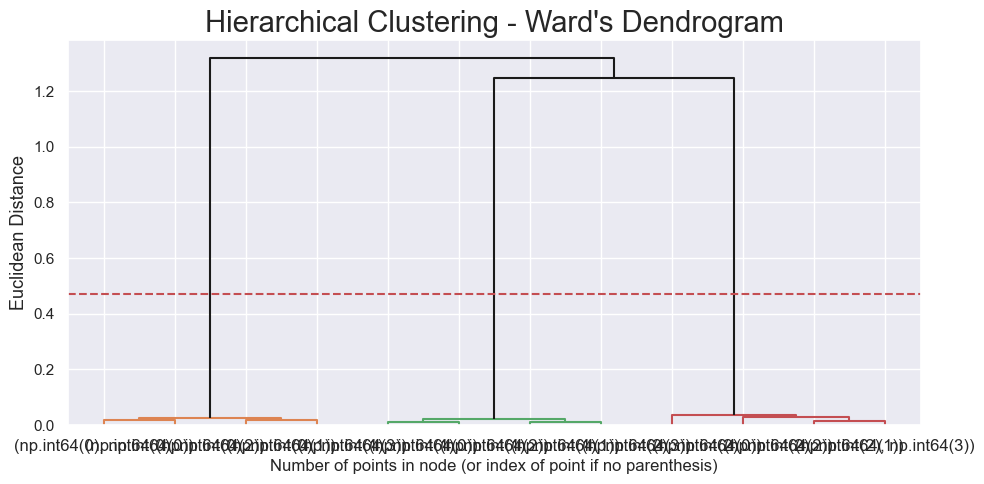

In [27]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids_2)


# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 0.47
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids_2.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


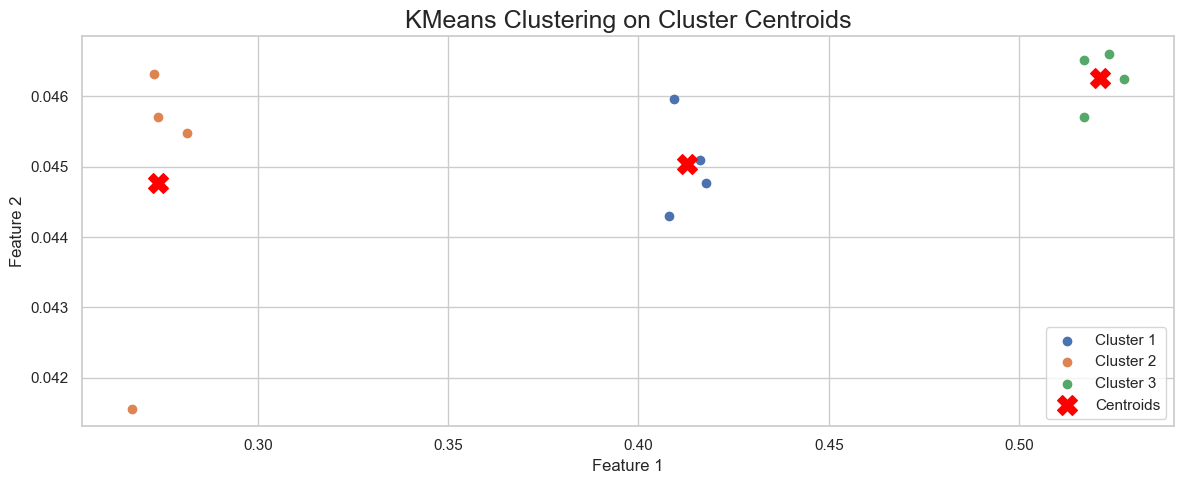

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(df_centroids_2)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 5))

data = df_centroids_2.values

for i in range(n_clusters):
    cluster_points = data[labels == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           s=200, c='red', marker='X', label='Centroids')

ax.set_title(f'KMeans Clustering on Cluster Centroids', fontsize=18)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()


In [29]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=3
)
hclust_labels = hclust.fit_predict(df_centroids_2)
df_centroids_2['hclust_labels'] = hclust_labels

df_centroids_2  # centroid's cluster labels

AvgMonthlyFlights  AvgDistancePerFlight  \
Merged_Cluster_1 BH_CLUSTER                                            
0                0                    0.517116              0.046512   
                 1                    0.523510              0.046602   
                 2                    0.516955              0.045701   
                 3                    0.527652              0.046249   
1                0                    0.409426              0.045969   
                 1                    0.416092              0.045099   
                 2                    0.408117              0.044302   
                 3                    0.417662              0.044764   
2                0                    0.272686              0.046315   
                 1                    0.281417              0.045480   
                 2                    0.266842              0.041562   
                 3                    0.273881              0.045711   

                             FlightsWithCompanionsRatio  PointsRedeemedRatio  \
Merged_Cluster_1 BH_CLUSTER                                                    
0                0                             0.235623             0.008946   
                 1                             0.237501             0.008691   
                 2                             0.232054             0.008634   
                 3                             0.237025             0.008828   
1                0                             0.231469             0.008855   
                 1                             0.226753             0.008347   
                 2                             0.223567             0.009034   
                 3                             0.227410             0.008732   
2                0                             0.239544             0.008322   
                 1                             0.223064             0.008801   
                 2                             0.209331             0.008981   
                 3                             0.214686             0.008265   

                             Customer Lifetime Value  UnredeemedPoints  \
Merged_Cluster_1 BH_CLUSTER                                              
0                0                          0.075307          0.394504   
                 1                          0.074251          0.404857   
                 2                          0.072336          0.392995   
                 3                          0.073391          0.404455   
1                0                          0.075461          0.315714   
                 1                          0.074538          0.321260   
                 2                          0.075468          0.313596   
                 3                          0.075541          0.323747   
2                0                          0.074895          0.208386   
                 1                          0.075646          0.218633   
                 2                          0.075216          0.198455   
                 3                          0.074307          0.212308   

                             PointsRedeemedRatio  KMPerRedeemedPoint  \
Merged_Cluster_1 BH_CLUSTER                                            
0                0                      0.008946            0.136238   
                 1                      0.008691            0.144094   
                 2                      0.008634            0.137314   
                 3                      0.008828            0.132948   
1                0                      0.008855            0.112629   
                 1                      0.008347            0.110105   
                 2                      0.009034            0.115425   
                 3                      0.008732            0.113094   
2                0                      0.008322            0.069246   
                 1                      0.008801            0.077916  

In [30]:
cluster_mapper = df_centroids_2['hclust_labels'].to_dict()


In [31]:
def safe_map_stage2(row):
    key = (row['Merged_Cluster_1'], row['BH_CLUSTER'])
    if row['Merged_Cluster_1'] == -1 or row['BH_CLUSTER'] == -1:
        return -1
    return cluster_mapper.get(key, -1)
df_2 = df.copy()
df_2['Merged_Clusters_2'] = df_2.apply(safe_map_stage2, axis=1)

In [32]:
df_2['Merged_Clusters_2'].value_counts(dropna=False)


Merged_Clusters_2
 2    6145
 0    5293
 1    5071
-1      65
Name: count, dtype: int64

In [33]:
df_2

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,VALUE_BASED_CLUSTER,LOYALTY_CLUSTER,Merged_Cluster_1,BH_CLUSTER,Merged_Clusters_2
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,0.354564,N,0.0,Standard,0.073946,0,2,2,1,0
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,0.860852,N,0.0,Standard,0.012155,0,0,1,1,2
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,0.358621,N,0.0,Standard,0.011545,1,2,2,1,0
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,0.503854,N,0.0,Standard,0.027909,0,1,0,3,1
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,0.736714,N,0.0,Standard,0.058015,0,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,0.005174,0.275862,0.053304,0.228518,0.774448,0.0,0.760933,0.099617,0.042146,0.088123,...,0.681947,N,0.0,Standard,0.066219,-1,1,-1,-1,-1
16570,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.950101,N,0.0,Standard,0.081874,-1,1,-1,-1,-1
16571,0.007082,0.321429,0.064760,0.166956,0.279639,0.0,0.244898,0.000000,0.000000,0.023810,...,0.212170,N,0.0,Standard,0.225581,-1,2,-1,-1,-1
16572,0.000000,0.090909,0.054571,0.000000,0.080725,0.0,0.064140,0.000000,0.000000,0.000000,...,0.071805,N,0.0,Standard,0.009009,-1,2,-1,-1,-1


In [34]:
df_2[df_2['Merged_Clusters_2']==-1]

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value,VALUE_BASED_CLUSTER,LOYALTY_CLUSTER,Merged_Cluster_1,BH_CLUSTER,Merged_Clusters_2
16509,0.000000,0.212000,0.045874,0.000000,0.771136,0.0,0.728863,0.092000,0.016000,0.076000,...,0.834888,N,0.0,Standard,0.073797,1,1,0,-1,-1
16510,0.011972,0.164609,0.030242,0.098781,0.297306,0.0,0.708455,0.049383,0.123457,0.065844,...,0.486410,N,0.0,Standard,0.018435,0,1,0,-1,-1
16511,0.005603,0.299320,0.043256,0.211038,0.347851,0.0,0.428571,0.129252,0.000000,0.142857,...,0.335497,N,0.0,Standard,0.006129,0,2,2,-1,-1
16512,0.014257,0.276596,0.043834,0.082945,0.364091,0.0,0.685131,0.106383,0.080851,0.093617,...,0.886815,N,0.0,Standard,0.077489,0,0,1,-1,-1
16513,0.000000,0.415493,0.068103,0.000000,0.650248,0.0,0.413994,0.169014,0.021127,0.119718,...,0.405680,N,0.0,Standard,0.073385,0,0,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,0.005174,0.275862,0.053304,0.228518,0.774448,0.0,0.760933,0.099617,0.042146,0.088123,...,0.681947,N,0.0,Standard,0.066219,-1,1,-1,-1,-1
16570,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.950101,N,0.0,Standard,0.081874,-1,1,-1,-1,-1
16571,0.007082,0.321429,0.064760,0.166956,0.279639,0.0,0.244898,0.000000,0.000000,0.023810,...,0.212170,N,0.0,Standard,0.225581,-1,2,-1,-1,-1
16572,0.000000,0.090909,0.054571,0.000000,0.080725,0.0,0.064140,0.000000,0.000000,0.000000,...,0.071805,N,0.0,Standard,0.009009,-1,2,-1,-1,-1


## Self Organizing Maps

### SOM - Component Planes

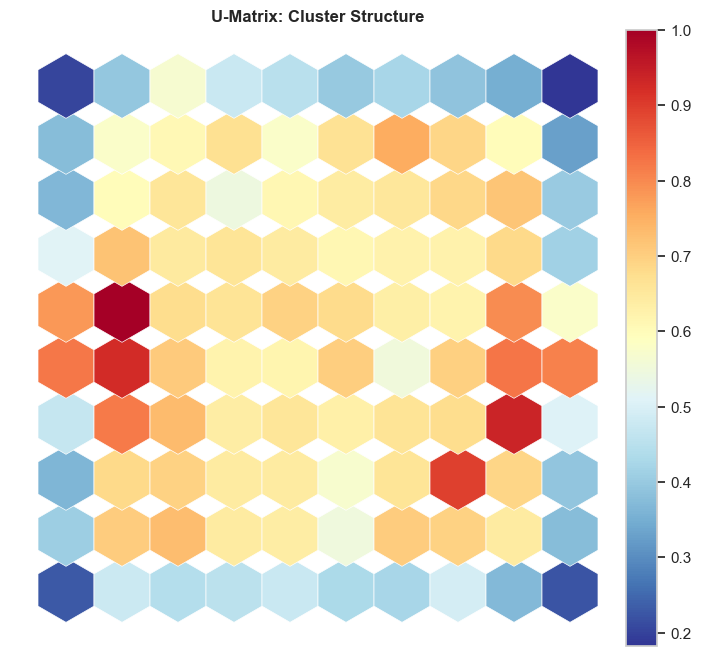

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import RegularPolygon
from matplotlib import colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from minisom import MiniSom

som_features = VB_col + LO_col + BH_col
som_data = df_2[som_features].values
N, M = 10, 10

som = MiniSom(x=N, y=M, input_len=som_data.shape[1], sigma=1.5, learning_rate=0.5, random_seed=42)
som.random_weights_init(som_data)
som.train_random(som_data, 50000)

# Calculate U-Matrix
u_matrix = som.distance_map()

def plot_hexagons(som_obj, ax, matrix, title="", cmap=cm.RdYlBu_r, annot=False):
    norm = mpl_colors.Normalize(vmin=np.min(matrix), vmax=np.max(matrix))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            wx, wy = som_obj.convert_map_to_euclidean((i, j))
            color = cmap(norm(matrix[i, j]))
            hex_poly = RegularPolygon((wx, wy), numVertices=6, radius=np.sqrt(1/3),
                                      facecolor=color, alpha=1, edgecolor='white', linewidth=0.5)
            ax.add_patch(hex_poly)
            if annot:
                val = round(matrix[i, j], 2)
                text_color = 'white' if matrix[i, j] > matrix.max()/2 else 'black'
                ax.text(wx, wy, val, ha='center', va='center', fontsize=8, color=text_color)
    ax.set_xlim(-1, matrix.shape[0])
    ax.set_ylim(-1, matrix.shape[1])
    ax.set_aspect('equal')
    ax.axis("off")
    ax.set_title(title, fontsize=12, fontweight='bold')
    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=ax_cb)

fig, ax = plt.subplots(figsize=(10, 8))
plot_hexagons(som_obj=som, ax=ax, matrix=u_matrix, title="U-Matrix: Cluster Structure", cmap=cm.RdYlBu_r, annot=False)
plt.show()


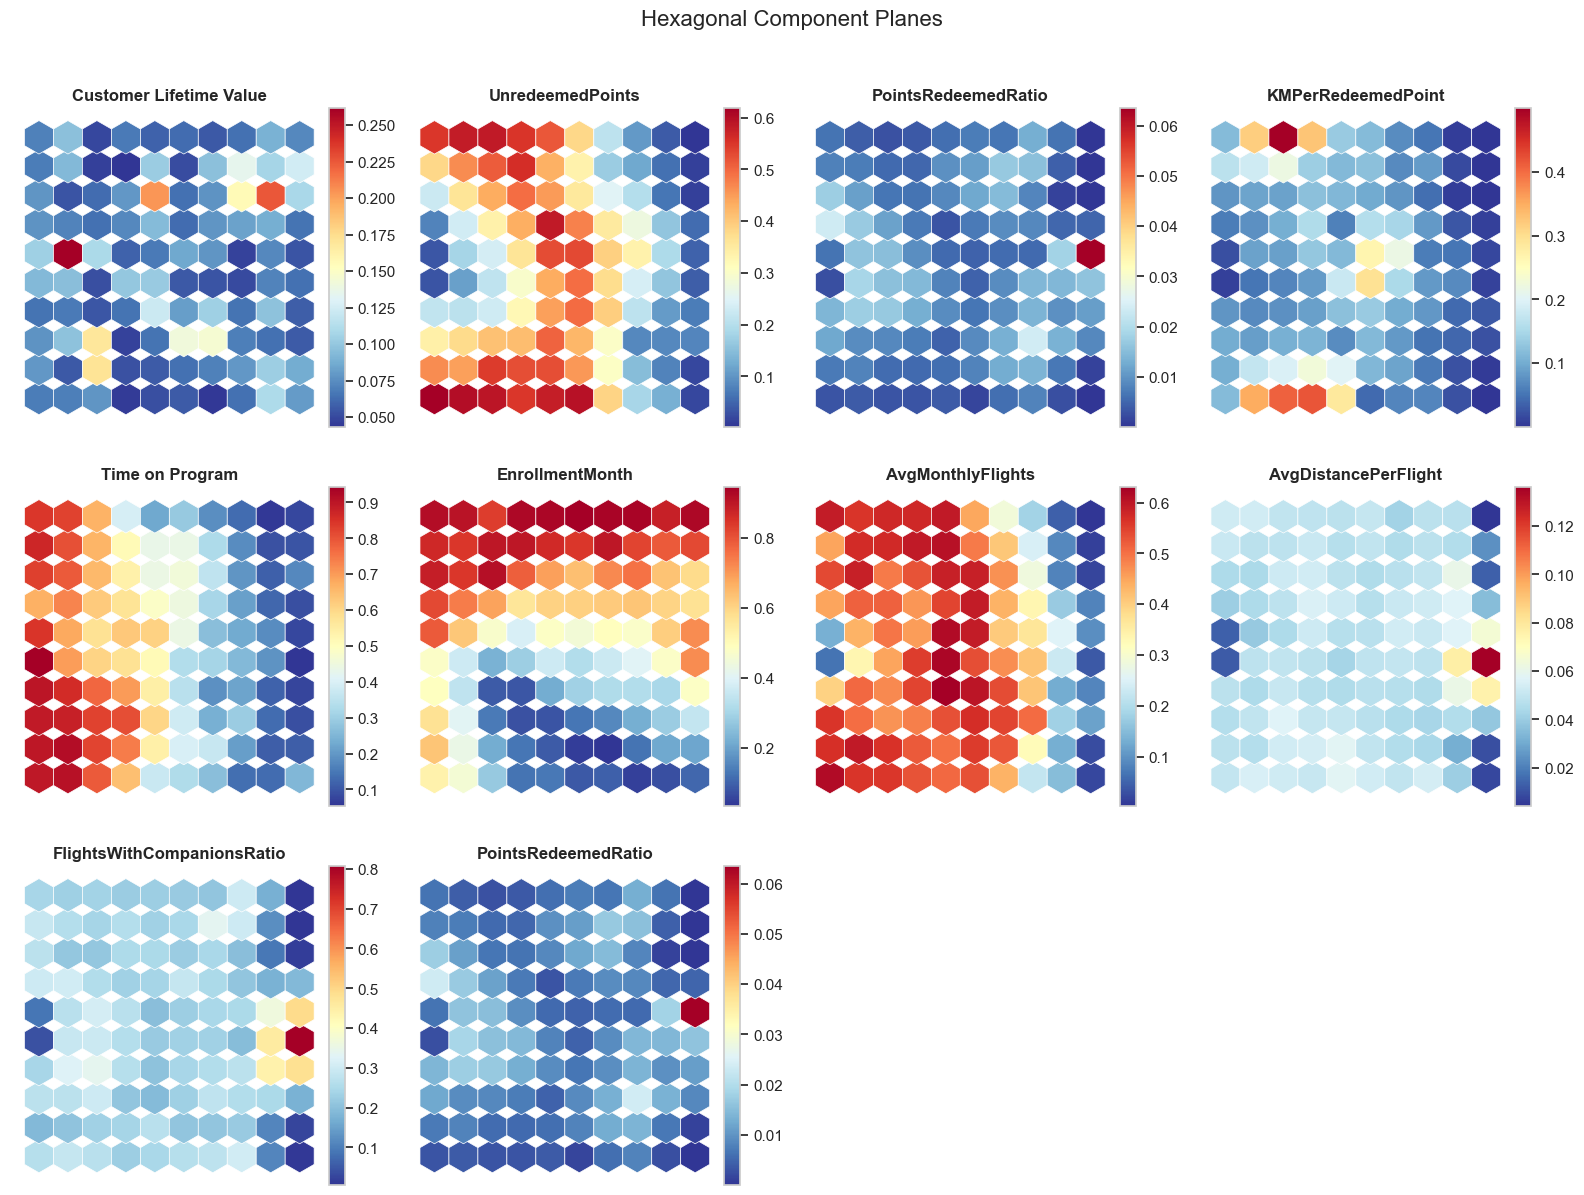

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import RegularPolygon
from matplotlib import colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from minisom import MiniSom
import math

som_features = VB_col + LO_col + BH_col
som_data = df_2[som_features].values
N, M = 10, 10

som = MiniSom(x=N, y=M, input_len=som_data.shape[1], sigma=1.5, learning_rate=0.5, random_seed=42)
som.random_weights_init(som_data)
som.train_random(som_data, 50000)

def plot_hexagons(som_obj, ax, matrix, title="", cmap=cm.RdYlBu_r, annot=False):
    norm = mpl_colors.Normalize(vmin=np.min(matrix), vmax=np.max(matrix))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            wx, wy = som_obj.convert_map_to_euclidean((i, j))
            color = cmap(norm(matrix[i, j]))
            hex_poly = RegularPolygon((wx, wy), numVertices=6, radius=np.sqrt(1/3),
                                      facecolor=color, alpha=1, edgecolor='white', linewidth=0.5)
            ax.add_patch(hex_poly)
            if annot:
                val = round(matrix[i, j], 2)
                text_color = 'white' if matrix[i, j] > matrix.max()/2 else 'black'
                ax.text(wx, wy, val, ha='center', va='center', fontsize=8)
    ax.set_xlim(-1, matrix.shape[0])
    ax.set_ylim(-1, matrix.shape[1])
    ax.set_aspect('equal')
    ax.axis("off")
    ax.set_title(title, fontsize=12, fontweight='bold')
    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=ax_cb)

weights = som.get_weights()
n_cols = 4
n_rows = math.ceil(len(som_features) / n_cols)
plt.figure(figsize=(16, 4 * n_rows))

for i, feature in enumerate(som_features):
    ax = plt.subplot(n_rows, n_cols, i+1)
    plot_hexagons(som, ax, weights[:, :, i], title=feature, cmap=cm.RdYlBu_r, annot=False)

plt.suptitle('Hexagonal Component Planes', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()


# UMAP

c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


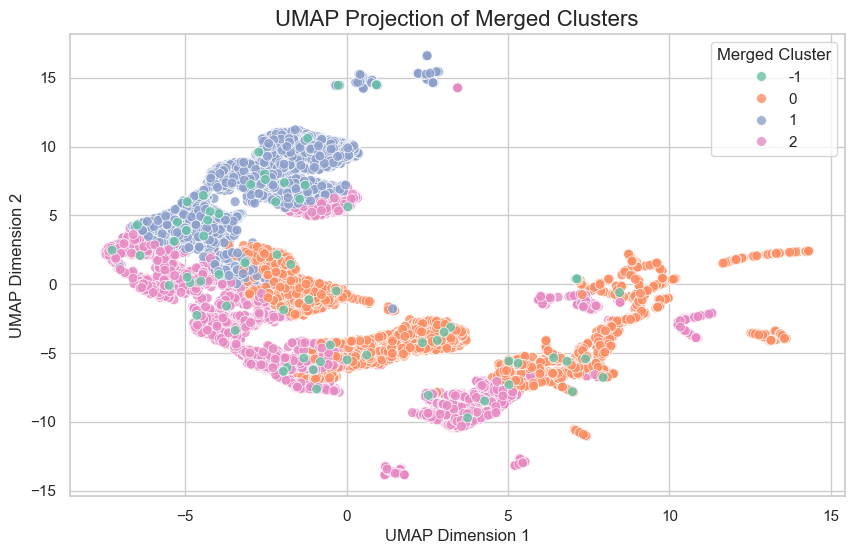

In [37]:
# Make sure to install umap-learn if not already installed
# %pip install umap-learn  # only needed once in the notebook

import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the feature lists used for clustering
col = LO_col + VB_col + BH_col

# Copy the dataframe
df_ = df_2.copy()

# Select only the clustering features
X = df_[col]

# Initialize and fit UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Create a DataFrame for plotting
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
embedding_df['Merged_Clusters_2'] = df_['Merged_Clusters_2'].values

# Plot UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Clusters_2',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


In [38]:
#  UMAP with different n_neighbors
n_neighbors_values = [2, 15, 100]
umap_results = {}

print("Running UMAP with different n_neighbors values\n")

for n_neigh in n_neighbors_values:
    print(f"Computing UMAP with n_neighbors={n_neigh}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neigh,
        min_dist=0.1,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df[col])
    umap_results[n_neigh] = X_umap


Running UMAP with different n_neighbors values

Computing UMAP with n_neighbors=2
Computing UMAP with n_neighbors=15
Computing UMAP with n_neighbors=100


c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


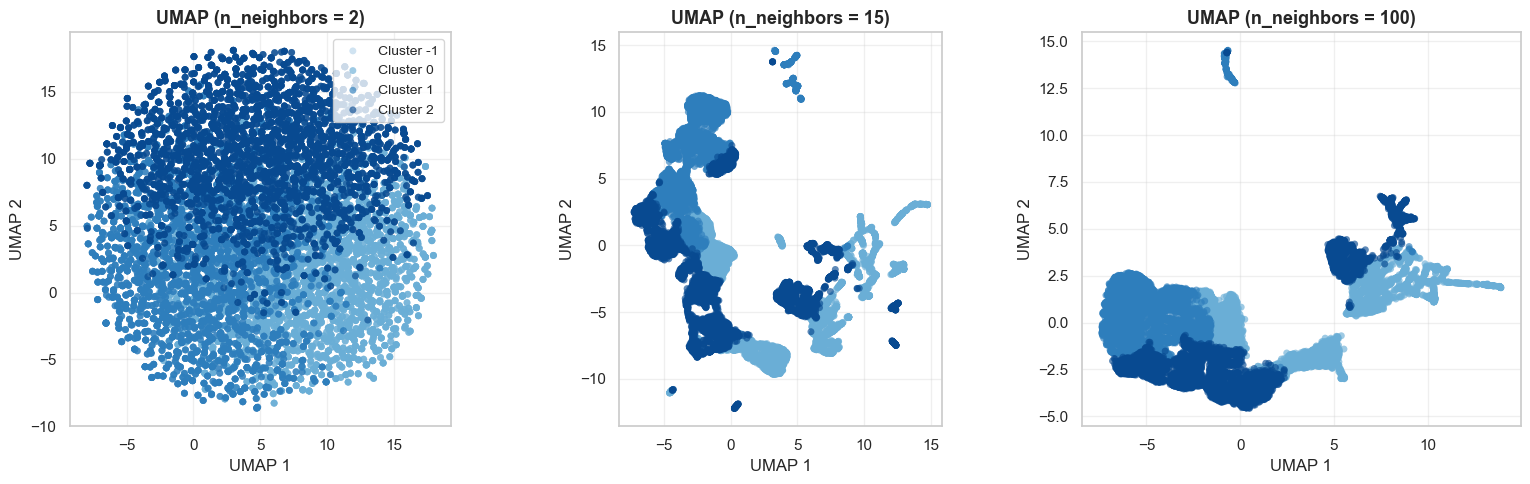

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap


X_no_vip = df_[VB_col + LO_col + BH_col]

n_neighbors_values = [2, 15, 100]
umap_results = {}

for n in n_neighbors_values:
    reducer = umap.UMAP(
        n_neighbors=n,
        min_dist=0.1,
        random_state=42
    )
    umap_results[n] = reducer.fit_transform(X_no_vip)

cluster_col = 'Merged_Clusters_2'
cluster_labels = sorted(df_[cluster_col].unique())
n_clusters = len(cluster_labels)

colors = cm.Blues(np.linspace(0.3, 0.9, n_clusters))
label_to_idx = {label: i for i, label in enumerate(cluster_labels)}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titles = [
    'UMAP (n_neighbors = 2)',
    'UMAP (n_neighbors = 15)',
    'UMAP (n_neighbors = 100)'
]

for idx, n_neigh in enumerate(n_neighbors_values):
    ax = axes[idx]
    X_umap = umap_results[n_neigh]

    for label in cluster_labels:
        mask = df_[cluster_col] == label
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            c=[colors[label_to_idx[label]]],
            s=25,
            alpha=0.65,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''
        )

    ax.set_title(titles[idx], fontsize=13, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

axes[0].legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


In [40]:
#UMAP with different min_dist
min_dist_values = [0.0, 0.1, 0.99]
umap_mindist_results = {}

print("Running UMAP with different min_dist values...\n")

for min_d in min_dist_values:
    print(f"Computing UMAP with min_dist={min_d}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=min_d,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df_[col])
    umap_mindist_results[min_d] = X_umap


Running UMAP with different min_dist values...

Computing UMAP with min_dist=0.0
Computing UMAP with min_dist=0.1
Computing UMAP with min_dist=0.99


c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


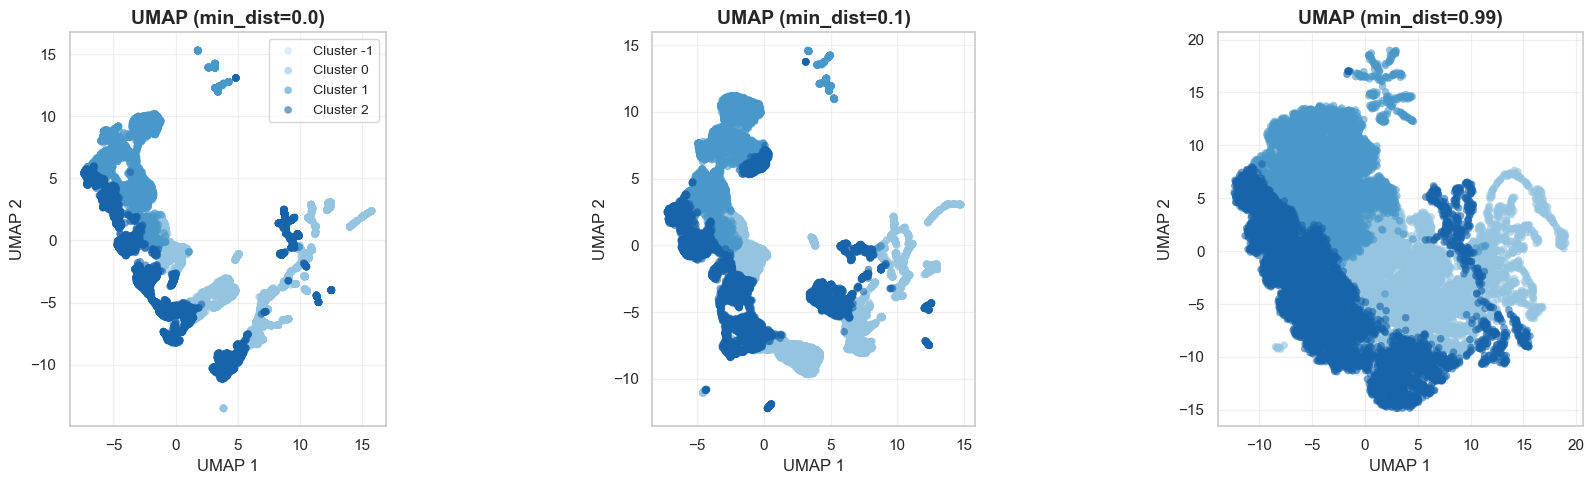

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

X_no_vip = df_[VB_col + LO_col + BH_col]

min_dist_values = [0.0, 0.1, 0.99]
umap_mindist_results = {}

for min_d in min_dist_values:
    reducer = umap.UMAP(n_neighbors=15, min_dist=min_d, random_state=42)
    embedding = reducer.fit_transform(X_no_vip)
    umap_mindist_results[min_d] = embedding

cluster_labels = sorted(df_['Merged_Clusters_2'].unique())
n_clusters = len(cluster_labels)

# Soft blue palette
palette = sns.color_palette("Blues", n_clusters)

fig, axes = plt.subplots(1, len(min_dist_values), figsize=(18, 5))
titles = ['UMAP (min_dist=0.0)', 'UMAP (min_dist=0.1)', 'UMAP (min_dist=0.99)']

for idx, min_d in enumerate(min_dist_values):
    ax = axes[idx]
    X_umap = umap_mindist_results[min_d]
    for i, label in enumerate(cluster_labels):
        mask = df_['Merged_Clusters_2'] == label
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1], color=palette[i],
                   alpha=0.6, s=30, edgecolors='none',
                   label=f'Cluster {label}' if idx == 0 else '')
    ax.set_title(titles[idx], fontsize=14, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

axes[0].legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


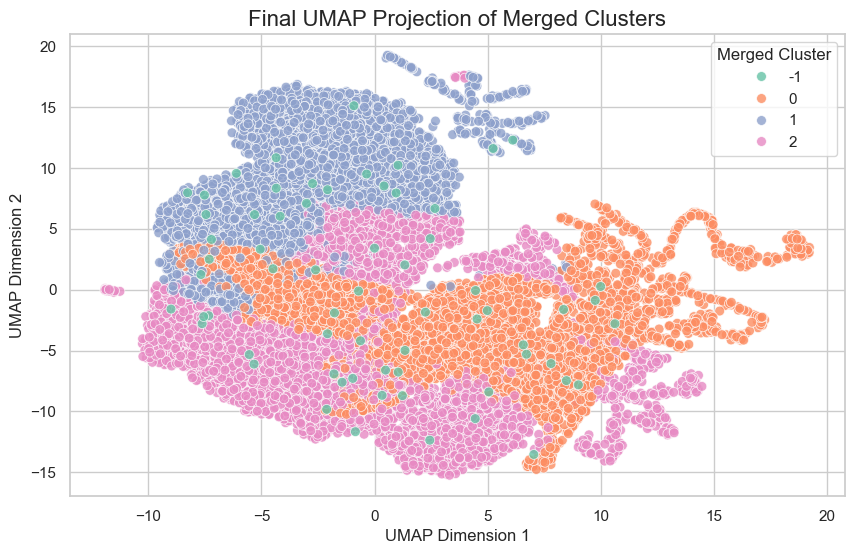

In [42]:
# Now do the final UMAP with chosen parameters (n_neigbors = 15, min_dist=0.1)
reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.99,
        random_state=42,
        n_jobs=1
)
X_umap_final = reducer.fit_transform(df_[col])

# Create a DataFrame for plotting
embedding_df_final = pd.DataFrame(X_umap_final, columns=['UMAP1', 'UMAP2'])
embedding_df_final['Merged_Clusters_2'] = df_['Merged_Clusters_2'].values
# Plot final UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df_final,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Clusters_2',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('Final UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


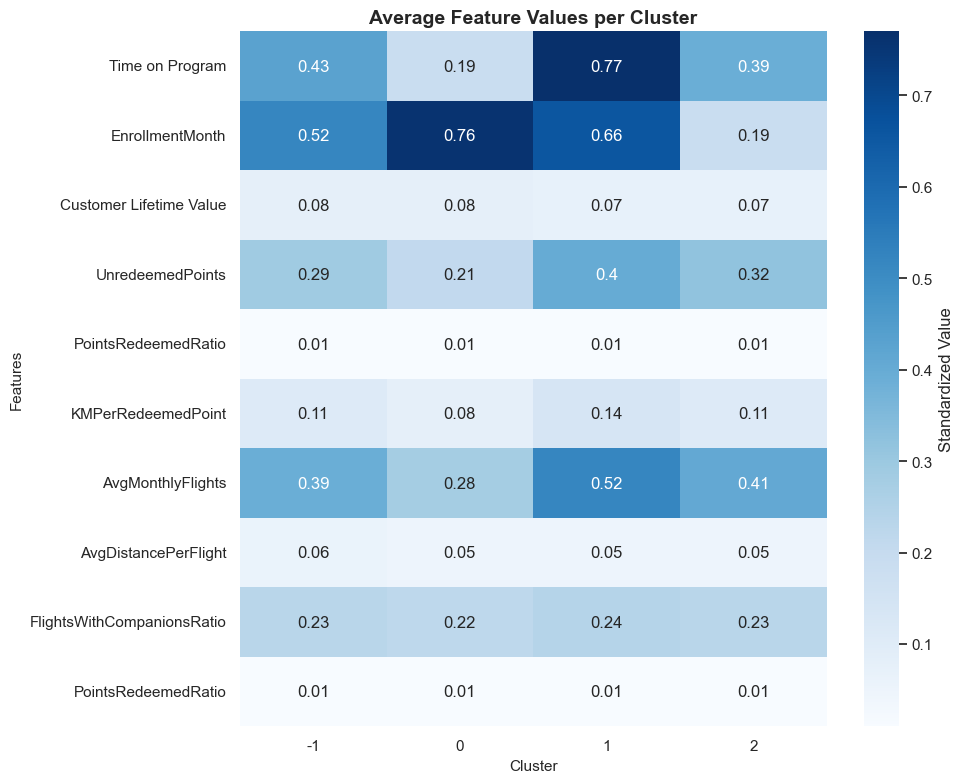

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean values per cluster
corr = df_.groupby('Merged_Clusters_2')[col].mean().round(2)
corr = corr.T

# Single figure with BLUE colormap
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap='Blues', 
            cbar_kws={'label': 'Standardized Value'})
plt.title('Average Feature Values per Cluster', 
          fontsize=14, weight='bold')
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Features', fontsize=11)

plt.tight_layout()
plt.show()

With this we can characterize the 4 clusters as the following:
- cluster 1: frequent flyers. The time on Program are the longest and they average 0.52 monthly flights and accumulate points without redeemed in 0.4. They are engaged and habitual
High retention priority
Good candidates for premium tier upgrades
Likely to respond to exclusive benefits
Risk: Could be on autopilot (check if still engaged or just habit)
- cluster 0: new and light users. the time on program are the lowest and the enrollment month is the highest, so recent joiners
- cluster 2: the tim eon program is about 1 and 2 years and they have a good average monthly flights with 0.32 of unredeemed points. active mid tier members
- cluster -1: the outliers, the unpredictables. time on program good and medium as so avgmonthlyflights

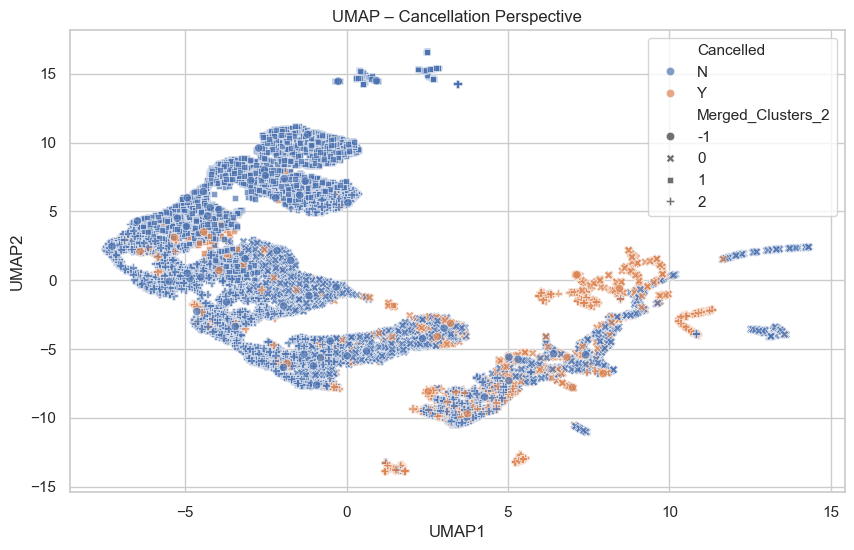

In [44]:
embedding_df['Cancelled'] = df_['Cancelled'].values

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df,
    x='UMAP1',
    y='UMAP2',
    hue='Cancelled',
    style='Merged_Clusters_2',
    alpha=0.7
)
plt.title('UMAP – Cancellation Perspective')
plt.show()

## PCA

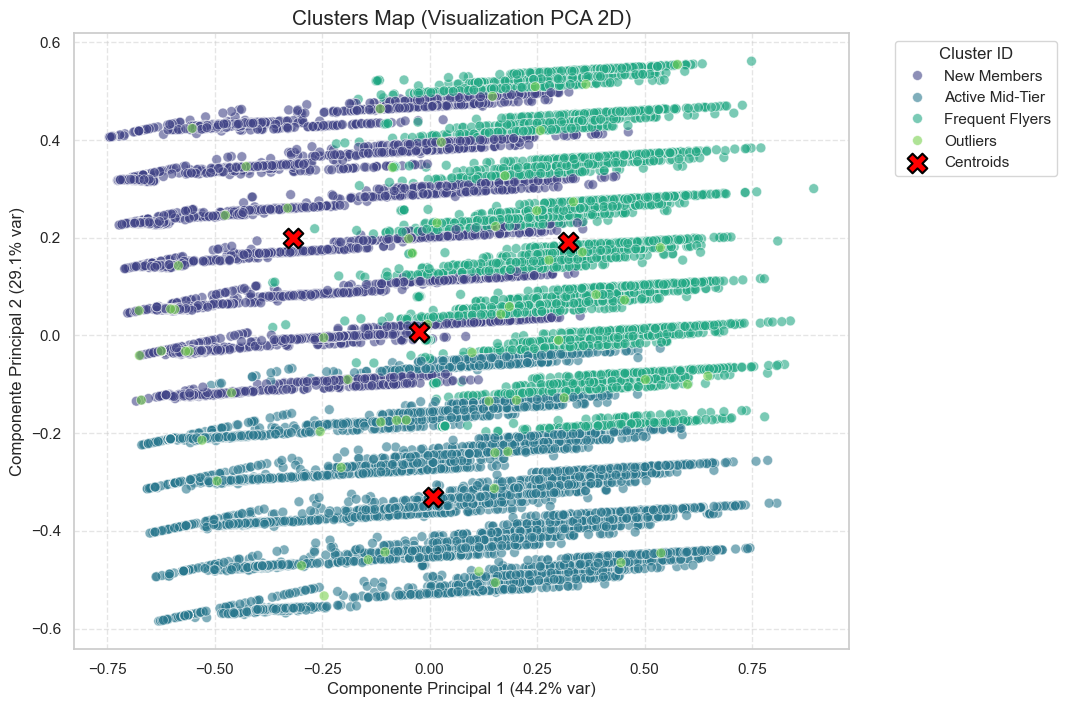

In [45]:
# Cluster Visualization (PCA)
cluster_names = {
    -1: 'Outliers',
    0: 'New Members',
    1: 'Frequent Flyers',
    2: 'Active Mid-Tier'
}
features_for_clustering = LO_col + VB_col + BH_col


# Calculate the PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_[features_for_clustering])

# Create a Data Frame
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_['Merged_Clusters_2'].values
df_pca['Profile'] = df_pca['Cluster'].map(cluster_names)

# Plot 
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Profile', 
    data=df_pca, 
    palette='viridis', 
    s=50, 
    alpha=0.6,
    edgecolor='w'
)

# Add the centroids
centroids_pca = df_pca.groupby('Profile')[['PC1', 'PC2']].mean()

# Red 'X'
plt.scatter(
    centroids_pca['PC1'], centroids_pca['PC2'], 
    marker='X', s=200, c='red', edgecolors='black', linewidths=1.5,
    label='Centroids'
)


plt.title('Clusters Map (Visualization PCA 2D)', fontsize=15)
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

if we just use this features, we will have a better discrimination:

Time on Program 

EnrollmentMonth 

UnredeemedPoints 

AvgMonthlyFlights 

KMPerRedeemedPoint 

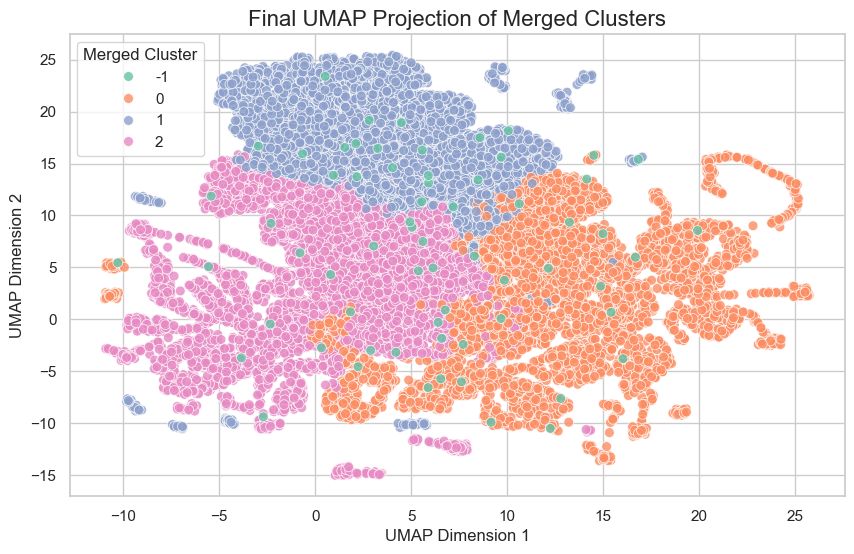

In [46]:

features_for_clustering = ['Time on Program', 'EnrollmentMonth','UnredeemedPoints','AvgMonthlyFlights','KMPerRedeemedPoint']


# Now do the final UMAP with chosen parameters (n_neigbors = 15, min_dist=0.1)
reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.99,
        random_state=42,
        n_jobs=1
)
X_umap_final = reducer.fit_transform(df_[features_for_clustering])

# Create a DataFrame for plotting
embedding_df_final = pd.DataFrame(X_umap_final, columns=['UMAP1', 'UMAP2'])
embedding_df_final['Merged_Clusters_2'] = df_['Merged_Clusters_2'].values
# Plot final UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df_final,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Clusters_2',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('Final UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


## Profilling

We will transform them into the original scale (we need to do this!!!!)

In [57]:
numeric_features = [
    'PointsRedeemedRatio', 'FlightsWithCompanionsRatio', 'AvgDistancePerFlight',
    'KMPerRedeemedPoint', 'UnredeemedPoints', 'AvgMonthlyFlights',
    'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul',
    'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec',
    'Time on Program', 'Reenroll', 'Customer Lifetime Value'
]
categorical_features = [
    'HasBonus', 'Province or State', 'Education', 'Income', 'Marital Status',
    'LoyaltyStatus', 'EnrollmentMonth', 'EnrollmentType', 'Cancelled'
]


In [58]:
df[numerical_cols]

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,sr_mar,...,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec,Income,EnrollmentMonth,Time on Program,Reenroll,Customer Lifetime Value
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.0,0.655977,0.026667,0.040000,0.146667,...,0.084444,0.137778,0.075556,0.155556,0.124444,0.828927,0.636364,0.354564,0.0,0.073946
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.0,0.714286,0.077551,0.024490,0.114286,...,0.106122,0.110204,0.081633,0.122449,0.138776,0.000000,0.181818,0.860852,0.0,0.012155
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.0,0.615160,0.094787,0.000000,0.066351,...,0.052133,0.180095,0.018957,0.090047,0.132701,0.000000,0.545455,0.358621,0.0,0.011545
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.0,0.314869,0.000000,0.111111,0.027778,...,0.074074,0.222222,0.185185,0.027778,0.277778,0.428451,0.636364,0.503854,0.0,0.027909
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.0,0.527697,0.022099,0.027624,0.165746,...,0.088398,0.005525,0.022099,0.088398,0.110497,0.809944,0.000000,0.736714,0.0,0.058015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16569,0.005174,0.275862,0.053304,0.228518,0.774448,0.0,0.760933,0.099617,0.042146,0.088123,...,0.107280,0.019157,0.076628,0.076628,0.057471,0.000000,0.363636,0.681947,0.0,0.066219
16570,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.235105,0.636364,0.950101,0.0,0.081874
16571,0.007082,0.321429,0.064760,0.166956,0.279639,0.0,0.244898,0.000000,0.000000,0.023810,...,0.154762,0.130952,0.000000,0.297619,0.392857,0.215461,0.545455,0.212170,0.0,0.225581
16572,0.000000,0.090909,0.054571,0.000000,0.080725,0.0,0.064140,0.000000,0.000000,0.000000,...,0.363636,0.500000,0.000000,0.136364,0.000000,0.000000,0.545455,0.071805,0.0,0.009009


In [61]:
# features used for scaling
# HERE! NAO ESTOU A CONSEGUIR FAZER !!!
features_to_scale = numeric_features  # e.g., numeric features used for clustering

# inverse transform scaled numeric features
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(df_[features_to_scale]),
    columns=features_to_scale,
    index=df_.index
)


# Compute numeric profile in original scale
numeric_profile = df_original_scale.groupby('Merged_Clusters_2')[features_to_scale].agg(['mean','median','std','min','max'])


numeric_profile


ValueError: operands could not be broadcast together with shapes (16574,21) (24,) (16574,21) 

In [ ]:
categorical_profile = {}
for col in categorical_features:
    categorical_profile[col] = df_.groupby('Merged_Clusters_2')[col].value_counts(normalize=True).unstack(fill_value=0)

categorical_profile


{'HasBonus': HasBonus                0.0       1.0
 Merged_Clusters_2                    
 -1                 0.984615  0.015385
  0                 0.951823  0.048177
  1                 0.990732  0.009268
  2                 0.974776  0.025224,
 'Province or State': Province or State   Alberta  British Columbia  Manitoba  New Brunswick  \
 Merged_Clusters_2                                                        
 -1                 0.015385          0.292308  0.046154       0.061538   
  0                 0.059135          0.256943  0.043265       0.037030   
  1                 0.054822          0.263064  0.038651       0.039834   
  2                 0.064280          0.263629  0.038731       0.036941   
 
 Province or State  Newfoundland  Nova Scotia   Ontario  Prince Edward Island  \
 Merged_Clusters_2                                                              
 -1                     0.015385     0.030769  0.323077              0.000000   
  0                     0.015681     

In [ ]:
# to better understanding the relation between the features and the clusters
with pd.ExcelWriter("cluster_profiling.xlsx") as writer:
    numeric_profile.to_excel(writer, sheet_name="Numeric Summary")
    for col, table in categorical_profile.items():
        table.to_excel(writer, sheet_name=f"{col} Distribution")


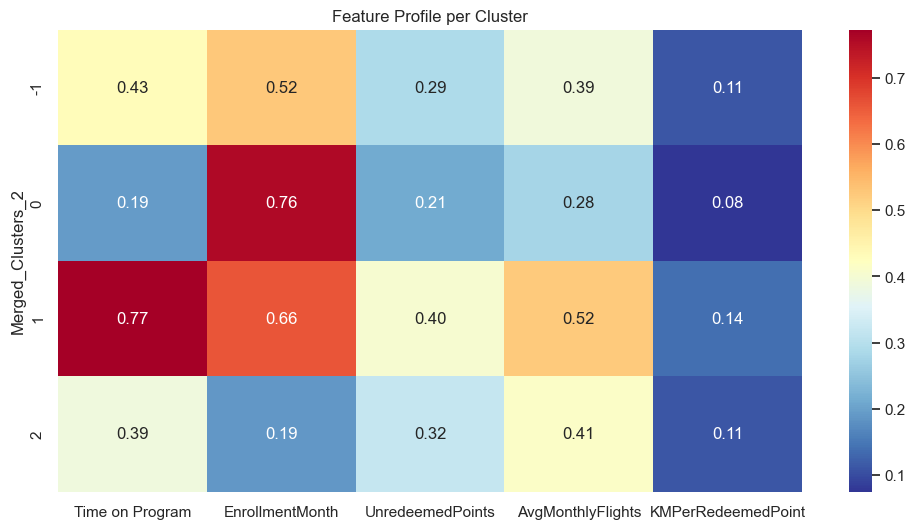

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_means = df_.groupby('Merged_Clusters_2')[features_for_clustering].mean()
plt.figure(figsize=(12,6))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap='RdYlBu_r')
plt.title("Feature Profile per Cluster")
plt.show()


In [ ]:
profiles = []
for c in df_['Merged_Clusters_2'].unique():
    cluster_df = df_[df_['Merged_Clusters_2']==c]
    top_feature = cluster_df[features_for_clustering].mean().idxmax()
    profiles.append(f"Cluster {c}: Highest in {top_feature}")
profiles


['Cluster 0: Highest in EnrollmentMonth',
 'Cluster 2: Highest in AvgMonthlyFlights',
 'Cluster 1: Highest in Time on Program',
 'Cluster -1: Highest in EnrollmentMonth']

In [ ]:
province_centroids = {
    'Alberta': (53.9333, -116.5765),
    'British Columbia': (53.7267, -127.6476),
    'Manitoba': (53.7609, -98.8139),
    'New Brunswick': (46.5653, -66.4619),
    'Newfoundland and Labrador': (53.1355, -57.6604),
    'Nova Scotia': (44.6820, -63.7443),
    'Ontario': (51.2538, -85.3232),
    'Prince Edward Island': (46.5107, -63.4168),
    'Quebec': (52.9399, -73.5491),
    'Saskatchewan': (52.9399, -106.4509),
    'Northwest Territories': (64.8255, -124.8457),
    'Nunavut': (70.2998, -83.1076),
    'Yukon': (64.2823, -135.0000)
}

In [ ]:
import folium
from folium.plugins import MarkerCluster
import numpy as np

# Create base map (centered in Canada)
map_canada_final_clusters = folium.Map(location=[56, -96], zoom_start=4)

# Define cluster colors
cluster_colors = {
    -1: 'gray',   # outliers
     0: 'blue',
     1: 'green',
     2: 'orange',
   
}

marker_cluster = MarkerCluster().add_to(map_canada_final_clusters)

# Columns to display in popup
features_to_show = ['Income', 'Customer Lifetime Value', 'Education']

for _, row in df_.iterrows():
    province = row['Province or State']
    if province not in province_centroids:
        continue  # skip unknown provinces

    lat, lon = province_centroids[province]
    lat += np.random.normal(0, 0.3)
    lon += np.random.normal(0, 0.3)

    cluster = row['Merged_Clusters_2']
    color = cluster_colors.get(cluster, 'black')

    popup_html = f"<b>Province:</b> {province}<br>"
    for feat in features_to_show:
        popup_html += f"<b>{feat}:</b> {row[feat]}<br>"

    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(marker_cluster)

# Display map
map_canada_final_clusters
map_canada_final_clusters.save("customer_clusters_map_final.html")


In [ ]:
!pip install dash

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# Features for plotting
plot_features = ['PointsRedeemedRatio', 'FlightsWithCompanionsRatio', 'AvgDistancePerFlight',
                 'KMPerRedeemedPoint', 'UnredeemedPoints', 'AvgMonthlyFlights']
categorical_filters = ['Education', 'Income', 'Province or State']

df_dash = df_.copy()
df_dash['Cluster'] = df_['Merged_Clusters_2'].astype(str)  # for colors

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("Interactive Cluster Visualization Dashboard"),
    
    html.Div([
        html.Label("Filter by Education"),
        dcc.Dropdown(
            id='filter-education',
            options=[{'label': edu, 'value': edu} for edu in sorted(df_dash['Education'].unique())],
            value=None,
            multi=True,
            placeholder="Select Education..."
        ),
    ], style={'width': '30%', 'display': 'inline-block', 'padding': 10}),
    
    html.Div([
        html.Label("Filter by Income"),
        dcc.Dropdown(
            id='filter-income',
            options=[{'label': inc, 'value': inc} for inc in sorted(df_dash['Income'].unique())],
            value=None,
            multi=True,
            placeholder="Select Income..."
        ),
    ], style={'width': '30%', 'display': 'inline-block', 'padding': 10}),
    
    dcc.Graph(id='cluster-3d-plot')
])

@app.callback(
    Output('cluster-3d-plot', 'figure'),
    Input('filter-education', 'value'),
    Input('filter-income', 'value')
)
def update_3d_plot(selected_edu, selected_income):
    filtered_df = df_dash.copy()
    if selected_edu:
        filtered_df = filtered_df[filtered_df['Education'].isin(selected_edu)]
    if selected_income:
        filtered_df = filtered_df[filtered_df['Income'].isin(selected_income)]
    
    fig = px.scatter_3d(
        filtered_df,
        x=plot_features[0],
        y=plot_features[1],
        z=plot_features[2],
        color='Cluster',
        hover_data=plot_features + categorical_filters,
        opacity=0.7,
        size_max=8
    )
    
    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title=plot_features[0],
            yaxis_title=plot_features[1],
            zaxis_title=plot_features[2]
        )
    )
    
    return fig

if __name__ == '__main__':
    app.run(debug=True)
